In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
import math
from numpy.linalg import inv
from IPython.display import Image
from scipy.special import expit

In [2]:
#INPUT PARAMETERS:
n_power = 0
dm_mass =  1 #GeV
step_size_cross_section =2e-26 * pow(dm_mass,0.15)
f_sky = 0.4
theta_fwhm = 1.5 * (np.pi/60./180.)
Tcmb = 2.7255 #2.726
l_min = 2
l_max = 5000
relative_bulk_velocity = 0.
#2e-26 * pow(dm_mass,0.15) <- n=0 
#4e-19 * pow(dm_mass,0.70) <- n=2 
#6e-13 * pow(dm_mass,1.25) <- n=4 
#8e-7 * pow(dm_mass,1.3)   <- n=6 
#3e-34 * pow(dm_mass,0.5)  <- n=-2
list_param = ['omega_b','omega_dmb', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmb']
list_fiducial = [0.0224, 0.12, 0.6730804,  2.2e-9, 0.96, 0.07, 0.0]
list_step = [0.0001,     0.001,    0.004,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

import time
start_time = time.time()
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time)

Starting Time = 12:44:02


In [3]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl','lensing': 'no','l_max_scalars': 5000,
    'omega_b': list_fiducial[0],'omega_dmb': list_fiducial[1],'h': list_fiducial[2],'A_s' : list_fiducial[3],'n_s' : list_fiducial[4], 'tau_reio' : list_fiducial[5],'sigma_dmb': list_fiducial[6],
    'm_dmb': dm_mass,
    'omega_cdm' : 1e-22,
    'n_dmb': n_power,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'T_ncdm':0.71611,
    'Vrel_dmb': relative_bulk_velocity
          }

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.raw_cl(5000)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']
      
Cl_est_kk = []
for i in ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append((1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i])) #unitless


# Lensing noise:

In [ ]:
'''a = np.load('noise/CMB_S4_noise.npy') #[uK^]2
N_KK = np.zeros(5001, 'float64')
N_KK[0:2501] = a[2] 
N_KK[ell > 2501] = 1e100'''

In [4]:
'''plt.plot(Cl_est_kk, 'k-',label="Cl_kk (unitless)")
plt.plot(N_KK, 'r--',label="Cl_kk (unitless)")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10,1e-1)
plt.xlim(2,5000)
plt.legend(loc="upper right")
plt.title('Cl_kk + nl_kk  n=0 1 GeV')
plt.show()'''

'plt.plot(Cl_est_kk, \'k-\',label="Cl_kk (unitless)")\nplt.plot(N_KK, \'r--\',label="Cl_kk (unitless)")\nplt.yscale(\'log\')\nplt.xscale(\'log\')\nplt.ylim(1e-10,1e-1)\nplt.xlim(2,5000)\nplt.legend(loc="upper right")\nplt.title(\'Cl_kk + nl_kk  n=0 1 GeV\')\nplt.show()'

# Temperature and Polarization noise:

In [5]:
sT = (1. * (np.pi/60./180. ))/(1.0e6*Tcmb) #Unitless to match fiducal Cl's
sP = np.sqrt(2)*sT #Unitless to match fiducal Cl's
f_sky = 0.65
theta_fwhm = 1.5 * (np.pi/60./180.)

l_min_t = 300
l_max_t = 5000
l_min_e = 100
l_max_e = 5000

from scipy.special import expit

N_TT = np.zeros(5001, 'float64')
N_EE = np.zeros(l_max_e+1, 'float64')

for l in range(300 , 5001):
            N_TT[l] = 0
            N_TT[l] += sT**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_TT[l] = 1/N_TT[l]
N_TT[ell < l_min_t] = 1e100
N_TT[ell > l_max_t] = 1e100

for l in range(100 , 5001):
            N_EE[l] = 0
            N_EE[l] += sP**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_EE[l] = 1/N_EE[l]
N_EE[ell < l_min_e] = 1e100
N_EE[ell > l_max_e] = 1e100

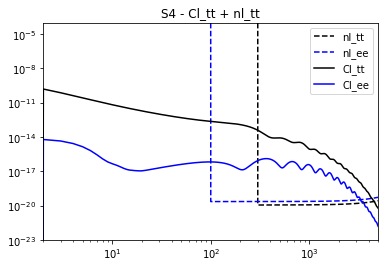

In [6]:
plt.plot(N_TT , 'k--',label="nl_tt")
plt.plot(N_EE , 'b--',label="nl_ee")
plt.plot(fiducial['tt'], 'k-',label="Cl_tt")
plt.plot(fiducial['ee'], 'b-',label="Cl_ee")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-23,1e-4)
plt.xlim(2,5000)
plt.legend(loc="upper right")
plt.title('S4 - Cl_tt + nl_tt')
plt.show()

In [7]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=5000):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.raw_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [8]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmb':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

<ipython-input-8-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


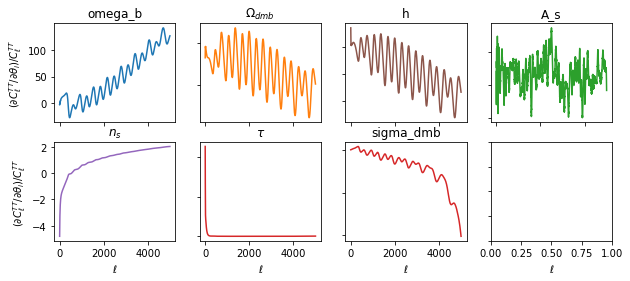

In [9]:
#Plotting Derivatives
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)
fig, axs = plt.subplots(2, 4, figsize=(10,4))
axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')
axs[0, 1].plot(dict_norm_der['omega_dmb'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmb}$')
axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')
axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')
axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')
axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')
axs[1, 2].plot(dict_norm_der['sigma_dmb'], 'tab:red')
axs[1, 2].set_title('sigma_dmb')
for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#fig.savefig("fisher_plots/derivative_C_l_TT_{}GeV_n={}_S4.png".format(str(dm_mass),str(n_power)))

We need:
 
$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$
[Wu et al. 2014](https://arxiv.org/abs/1402.4108)


Computing $C_l$ only using temperature power spectrum for planck baseline. 

$$ \mathbf{C}_{\ell} \equiv 
  \left( {\begin{array}{cc}
   C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)
 $$

Let :
$$   \mathbf{Q}^{i}_{nm} =\, \left( {C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \right)  =
  \left( {\begin{array}{cc}
    C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)^{-1}
   \left( {\begin{array}{cc}
    \frac{\partial C_{\ell}^{TT}}{\partial \theta_i } & \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } & 0 \\
   \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } &\frac{\partial C_{\ell}^{EE}}{\partial \theta_i } & 0 \\
    0 & 0 & \frac{\partial C_{\ell}^{\kappa\kappa}}{\partial \theta_i } \\
  \end{array} } \right)
$$
So that:
$$  F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left[  \mathbf{Q}_{i}  \mathbf{Q}_{j} \right]
$$

In [11]:
#dC_lpp = compute_d_cl(list_param_step, params, 'pp', fiducial)

In [ ]:
'''new_dC_lpp = {}
for k, a in dC_lpp.items():
    a[:80] = [0 for i in range(len(a[:80]))]
    a[2500:] = [0 for i in range(len(a[2500:]))]
    new_dC_lpp[k] = a'''

In [ ]:
'''dC_lkk = {}
for k, array in dC_lpp.items():
    list_a = []
    for l, a in enumerate(array):
        if l < 2:
            list_a.append(0)
        else:
            list_a.append((1.0/4) * (math.factorial(l+2)/math.factorial(l-2)) * a)        
    dC_lkk[k] = np.array(list_a)'''

In [12]:
MAT_d_cl = [ 
            [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial)],
            [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial)]
           ]

MAT_cl = [ [fiducial['tt'] + N_TT, fiducial['te']], 
           [fiducial['te'], fiducial['ee'] + N_EE]
         ]

<ipython-input-8-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [ ]:
'''new_MAT_d_cl_0_0 = {}
for key, array in MAT_d_cl[0][0].items():
    new_array = []
    for i, a in enumerate(array):
        if i <= 300:
            new_array.append(0)
        else:
            new_array.append(a)
    new_MAT_d_cl_0_0[key] = np.array(new_array)

MAT_d_cl[0][0] = new_MAT_d_cl_0_0'''

In [13]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l]], 
              [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l]]]
    
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l]],
          [MAT_cl[1][0][l], MAT_cl[1][1][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 5000):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [14]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)
    
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 2.215426333193998e-05
omega_dmb 0.0006459547695437474
h 0.0023437667478938004
A_s 3.0200952428709067e-09
n_s 0.0018703133573394278
tau_reio 0.6861081605930796
sigma_dmb 1.7242802743311502e-26


In [15]:
print(F)

[[38689341457.83366, -5362818719.258043, -1514628752.0685098, 2.0123291621707786e+17, 722016676.7070714, -885457065.0324104, -4.065923212751084e+31], [-5362818719.258043, 1306325308.2861695, 356281042.1818493, -2.5035569924397972e+16, -81581231.77670474, 110165849.10599668, 2.9511813400750975e+30], [-1514628752.0685098, 356281042.18184936, 97987110.05910282, -6652990128963406.0, -22855687.255963955, 29275128.997670814, 8.76688774010309e+29], [2.0123291621707786e+17, -2.5035569924397972e+16, -6652990128963406.0, 1.8112240032056673e+24, 5235339837961014.0, -7970711506386538.0, -2.7536525304372616e+38], [722016676.7070714, -81581231.77670474, -22855687.255963955, 5235339837961014.0, 17203704.706812263, -23038461.739678524, -9.574876668283687e+29], [-885457065.0324104, 110165849.10599668, 29275128.997670814, -7970711506386537.0, -23038461.739678524, 35076971.37057968, 1.211571279049219e+30], [-4.065923212751084e+31, 2.9511813400750975e+30, 8.76688774010309e+29, -2.7536525304372616e+38, -9.

generating new axis
['omega_b', 'omega_dmb', 'h', 'A_s', 'n_s', 'tau_reio', 'sigma_dmb']


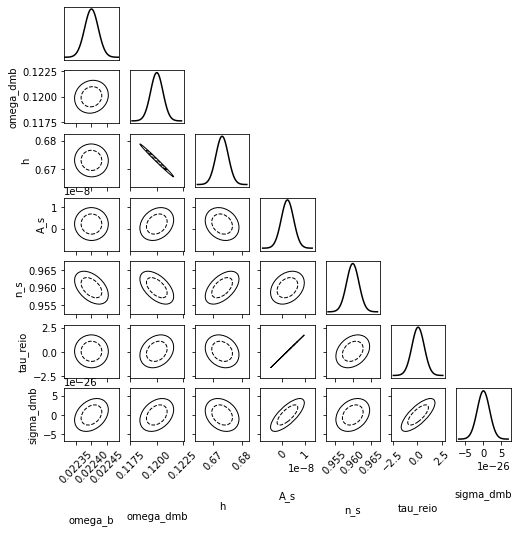

In [16]:
import fishchips.util
cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);
fig.savefig("fisher_plots/triagular_ellipses_{}GeV_n={}_S4_no_lensing.png".format(str(dm_mass),str(n_power)))


In [17]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48,"2-sigma zack's method =")

In [18]:
print(dat)

('n-power=', 0, 'dm_mass=', 1, 'stepsize =', 2e-26, 'fisher matrix =', [[38689341457.83366, -5362818719.258043, -1514628752.0685098, 2.0123291621707786e+17, 722016676.7070714, -885457065.0324104, -4.065923212751084e+31], [-5362818719.258043, 1306325308.2861695, 356281042.1818493, -2.5035569924397972e+16, -81581231.77670474, 110165849.10599668, 2.9511813400750975e+30], [-1514628752.0685098, 356281042.18184936, 97987110.05910282, -6652990128963406.0, -22855687.255963955, 29275128.997670814, 8.76688774010309e+29], [2.0123291621707786e+17, -2.5035569924397972e+16, -6652990128963406.0, 1.8112240032056673e+24, 5235339837961014.0, -7970711506386538.0, -2.7536525304372616e+38], [722016676.7070714, -81581231.77670474, -22855687.255963955, 5235339837961014.0, 17203704.706812263, -23038461.739678524, -9.574876668283687e+29], [-885457065.0324104, 110165849.10599668, 29275128.997670814, -7970711506386537.0, -23038461.739678524, 35076971.37057968, 1.211571279049219e+30], [-4.065923212751084e+31, 2.9

In [21]:
outF = open("fisher_data/S4_n={}/{}GeV_no_lensing.txt".format(str(n_power),str(dm_mass)), "w")

for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()

In [20]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1397.139761209488 seconds ---
